TQP3M9037 thermal analysis
====
Last updated: 3 Aug 2018  
  
This is a simplified thermal analysis of the amplifiers used in the RF front end section of the CBITS phased array.  The analysis follows example 15-8 in Heat Transfer book, page 807. The RF front end has four TQP3M9037 amplifiers per antenna element.  These are each biased at 5 volts DC with a typical Idd of 70mA. The self-heating will affect the noise figure and gain of the amplifier.  
  
Assuming some symmetry in the layout of the components, only two amplifiers  will be analyzed.  The thermal conductive path is through the copper traces and vias to a ground plane.  It is assumed that a heat frame will conduct the thermal energy to the ambient environment.  To analyze without the heat frame, the thermal contact resistant is set to 50 C/W.  
  
The ambient environment  is either, -55C, -34C or 70C for this analysis.
  
The PCB material is not part of the analysis since copper is much more thermally conductive than any of the common RF laminates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# use the pint library to keep track of physical units
import pint
ureg = pint.UnitRegistry()

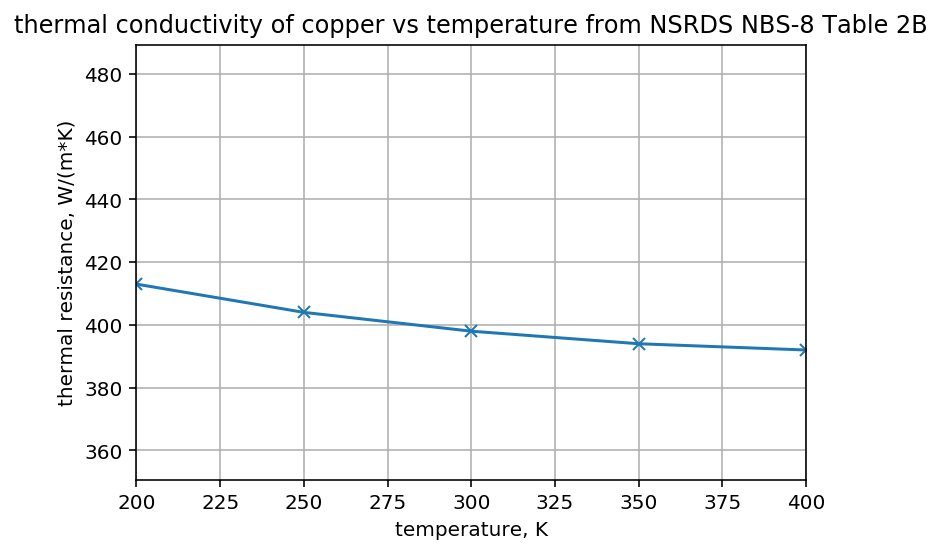

In [3]:
# thermal conductivity of copper vs temperature from NSRDS NBS-8 Table 2B
# various temperatures to be analyzed: 218.15 = -55C, 239.15 = -34C, 298.12 = 25C, 343.15k = 70C
temp = np.array([100,150,200,250,300,350,400,500,600,700,800,900,1000])
k_cu = np.array([483,428,413,404,398,394,392,388,383,377,371,364,357])
plt.plot(temp,k_cu,'-x')
plt.grid()
plt.title('thermal conductivity of copper vs temperature from NSRDS NBS-8 Table 2B')
plt.xlabel('temperature, K')
plt.ylabel('thermal resistance, W/(m*K)')
plt.xlim(200,400)
plt.show()

In [5]:
# find the average thermal conductivity across the range of interest, 200 to 400 K
k_cu_avg = k_cu[2:6].sum()/len(k_cu[2:6])
print(k_cu_avg)

k_cu = k_cu_avg*ureg.watt/(ureg.meter*ureg.degK)  # copper thermal conductivity, W/(m*K)
print('average thermal conductivity = {:.1f}'.format(k_cu))

402.25
average thermal conductivity = 402.2 watt / kelvin / meter


In [6]:
# amplifier bias
Vdd = 5*ureg.volt  # volts
Idd = 70*ureg.milliamp  # 70mA typical
P = Vdd*Idd
print('power dissapated = {:.2f}'.format(P.to('watt')))

# thermal conductivity, from datasheet
theta_jc = 53.4*ureg.degK/ureg.watt # Thermal Resistance, θjc channel to case, °C/W

power dissapated = 0.35 watt


In [7]:
# power used by front end RF amps
total_pwr_rf_amps = 0
# L-Band
num_ele = 140
amps_per_ele = 4
print('L-Band: power used by RF front end amps = {:.1f}'.format(num_ele*amps_per_ele*P.to('watt')))
total_pwr_rf_amps = num_ele*amps_per_ele*P

# S-Band
num_ele = 512
amps_per_ele = 4
print('S-Band: power used by RF front end amps = {:.1f}'.format(num_ele*amps_per_ele*P.to('watt')))
total_pwr_rf_amps += num_ele*amps_per_ele*P

# C-Band, amp is a QPL9503, Vdd=5V, Idd=56mA
num_ele = 1536
amps_per_ele = 6
P_cband = (5*ureg.volt)*(56*ureg.milliamp)
print('C-Band: power used by RF front end amps = {:.1f}'.format(num_ele*amps_per_ele*P_cband.to('watt')))

total_pwr_rf_amps += num_ele*amps_per_ele*P_cband
print('power used by the front end RF amps = {:.1f}'.format(total_pwr_rf_amps.to('watt')))

L-Band: power used by RF front end amps = 196.0 watt
S-Band: power used by RF front end amps = 716.8 watt
C-Band: power used by RF front end amps = 2580.5 watt
power used by the front end RF amps = 3493.3 watt


In [8]:
# overall size of the aperture
length = 256.5
height = 60.8
area = length*height
#areas of small triangles
a1 = 39.15*12.03/2
a2 = 39.15*10.3/2
a3 = 62.75*12.03/2
a4 = 62.75*10.3/2
area = area - (a1 + a2 + a3 + a4)  # in^2
print('total area of aperture = {:,.2f} in^2'.format(area))
area = area*0.00064516 # convert to m^2
print('total area of aperture = {:.3f} m^2'.format(area))

total area of aperture = 14,457.49 in^2
total area of aperture = 9.327 m^2


In [9]:
# analyze antenna as a plate with height of 60 inches for air at 1 atm, 20C
height = 39.15*60  # analyze along heigh deminsion, convert to m
air_vel = 4  # allow a bit of air flow, m/s
print('air velocity = {:.0f} m/s'.format(air_vel))
Tair = 20  # temperature of air

# calculate Reynolds number
v = 1.516e-5  # kinematic viscosity  for air at 1 atm, 20C
Re = air_vel*height/v # Reynolds at end of the plate
print('Reynolds at end of plate = {:.3e}'.format(Re))

Pr = 0.7309  # Prandtl number for air at 1 atm, 20C

# Nusselt number for turbulant flow, disreguarding laminar flow because of the long dimension
Nu = (0.0295*Re**0.8)*Pr**(1/3)  # see page 373 for this equation
print('Nusselt number = {:.1f}'.format(Nu))

k = 0.02514  # thermal conductivity for air at 1 atm, 20C
h = (k/height)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

As = area*2  # surface area, times 2 to used both sides of the plate
Q = 3493 # thermal load from above, watts

# re-arranging Q = h*As*(Ts-Tair)
Ts = Q/(h*As) + Tair
print('surface temperature = {:.1f} C'.format(Ts))

air velocity = 4 m/s
Reynolds at end of plate = 6.198e+08
Nusselt number = 287234.4
convective heat transfer coefficient of the flow = 3.074
surface temperature = 80.9 C


The high surface temperature calculated for a simple plate indicates that the thermal design needs a closer look.

In [10]:
# thermal resistance of a via, TI AN-2020 p6
via_length = 0.063*ureg.inch
via_length.ito(ureg.meter)  # convert variable inplace to meters
via_radius = 0.014*ureg.inch/2 # 14 mils via diameter
via_radius.ito(ureg.meter)
plating_thickness = 0.001*ureg.inch # 1 mil plate thickness
plating_thickness.ito(ureg.meter)
R_via = (via_length/k_cu)/(np.pi*(via_radius**2-(via_radius-plating_thickness)**2))
print('via thermal resistivity = {:.1f}'.format(R_via))

# thermal pad and thermal vias
tp_l = 0.7*ureg.mm
tp_l.ito(ureg.meter)
tp_w = 1.6*ureg.mm
tp_w.ito(ureg.meter)
A_tp = tp_l*tp_w
L_tp = 0.0014*ureg.inch # copper thickness of thermal pad
L_tp.ito(ureg.meter)
R_tp = L_tp/(k_cu*A_tp)  # thermal resistance of thermal pad
n_vias = 3  # number of vias
R_tp = R_tp + R_via/n_vias
print('resistance of thermal pad w/ vias = {:.1f}'.format(R_tp))

# copper gound plane, 1st segment, assume ground plane is 2x2 inches
gp1_l = 2*ureg.inch
gp1_l.ito(ureg.meter)
gp1_w = 2*ureg.inch
gp1_w.ito(ureg.meter)
A_gp1 = gp1_l*gp1_w # area of ground plane section #1
L_gp1 = 0.003*ureg.inch # 1 oz copper ground plane section #1
L_gp1.ito(ureg.meter)
R_gp1 = L_gp1/(k_cu*A_gp1)  # thermal resistance of ground plane length 1
print('resistance of ground plane seg #1 = {:.3e}'.format(R_gp1))

# copper gound plane, 2nd segment, assume ground plane is 2x2 inches
gp2_l = 2*ureg.inch
gp2_l.ito(ureg.meter)
gp2_w = 2*ureg.inch
gp2_w.ito(ureg.meter)
A_gp2 = gp2_l*gp2_w # area of ground plane section #2
L_gp2 = 0.0014*ureg.inch # 1 oz copper ground plane section #2
L_gp2.ito(ureg.meter)
R_gp2 = L_gp2/(k_cu*A_gp2)  # thermal resistance of ground plane section #2
print('resistance of ground plane seg #2 = {:.3e}'.format(R_gp2))

# path of heat frame to ambient
hf_l = 0.2*ureg.inch
hf_l.ito(ureg.meter)
hf_w = 0.2*ureg.inch
hf_w.ito(ureg.meter)
A_hf = hf_l*hf_w # area of heat frame
L_hf = 5*ureg.inch # thickness of frame exit
L_hf.ito(ureg.meter)
R_hf = L_hf/(k_cu*A_hf)  # thermal resistance of heat frame
print('resistance of heat frame = {:.1f}'.format(R_hf))

via thermal resistivity = 151.0 kelvin / watt
resistance of thermal pad w/ vias = 50.4 kelvin / watt
resistance of ground plane seg #1 = 7.341e-05 kelvin / watt
resistance of ground plane seg #2 = 3.426e-05 kelvin / watt
resistance of heat frame = 12.2 kelvin / watt


In [11]:
# temperatures at various points
Q2 = 2*P  # since there are 2 amplifiers on each side of symmetry plane
Rc = 1*ureg.degK/ureg.watt  # thermal resistance of PCB to heat frame contact, either 1 or 50
# 218.15 = -55C, 239.15 = -34C, 298.15 = 25C, 343.15k = 70C
T0 = 239.15*ureg.degK  # air temperature
#T0.ito(ureg.degK)
T1 = T0+Q2*R_hf+Q2*Rc

T2 = T1+Q2*R_gp2
Q1 = P
T3 = T2+Q1*R_gp2
T4 = T3+Q1*R_tp
print('case temperature of device #1 = {:.1f}'.format(T4.to(ureg.degC)))

Tj1 = T4+theta_jc*Q1
print('junction temperature of device #1 = {:.1f} C'.format(Tj1.to(ureg.degC)))
if Tj1 < 233.15*ureg.degK or Tj1 > 378.15*ureg.degK:
    print('recommended operating temperature exceeded')

case temperature of device #1 = -7.1 degC
junction temperature of device #1 = 11.6 degC C


Recommended Operating Conditions:  
T CASE −40 to +105 °C  
Tj for >106 hours MTTF +190 °C max  
datasheet probably refers to case temperature for test conditions  

**Conclusion:** The analysis shows that some type of heat frame appears to be required.  The temperature of the amplifier with an air temperature of -43C is 26C w/o the heat frame and -8C with the heat frame.

## Calculations for a thermal via
Raytheon says their thermal via is 35.913 C/W for via with a solder plug.  Don't know via size.

In [12]:
# thermal resistance of a via, TI AN-2020 p6
via_length = 0.063*ureg.inch
via_length.ito(ureg.meter)  # convert variable inplace to meters
via_radius = 0.014*ureg.inch/2 # 14 mils via diameter
via_radius.ito(ureg.meter)
plating_thickness = 0.001*ureg.inch # 1 mil plate thickness
plating_thickness.ito(ureg.meter)
R_via = (via_length/k_cu)/(np.pi*(via_radius**2-(via_radius-plating_thickness)**2))
print('via thermal resistivity = {:.1f}'.format(R_via))

via thermal resistivity = 151.0 kelvin / watt


In [14]:
# thermal resistance of solid Cu via
via_length = 0.063*ureg.inch
via_length.ito(ureg.meter)  # convert variable inplace to meters
via_radius = 0.014*ureg.inch/2 # 14 mils via diameter
via_radius.ito(ureg.meter)

R_via = (via_length/k_cu)/(np.pi*via_radius**2)
print('via thermal resistivity = {:.1f}'.format(R_via))

via thermal resistivity = 40.1 kelvin / watt
